
<h1>Power System Analysis and Optimization (5XWA0)</h1>
<h2>Economic dispatch with generation constraints in PYOMO</h2>

<b>MSc Irena Dukovska</b> <br />
<b>Dr. Nikolaos Paterakis</b> <br />
  Electrical Energy Systems Group <br />
  Department of Electrical Engineering <br />
  Eindhoven University of Technology <br />
  (i.dukovska@tue.nl, n.paterakis@tue.nl) <br /><br />
  

<h2>Introduction</h2>

In this tutorial we will be developing a model in Python in order to solve and examine the solution of a simple form of the Economic Dispatch problem.

The optimization problem is formulated as follows:

\begin{align}
&\text{Minimize} \ C = \sum_{i}(a_i+b_i \cdot P_i + c_i \cdot P_i^2) \\
&\text{subject to:} \\
&\sum_{i} P_i = D \ \forall i \\
&P_i^{min} \leq P_i \leq P_i^{max} \ \forall i \\
&P_i \geq 0 \ \forall i
\end{align}

The goal of the optimization problem is to find the optimal power output of each unit in order to serve the total load at a minimum cost.

<b>In this tutorial we will:</b> <br>
1) develop an optimization model using Pyomo to solve the problem above <br>
2) show how to extract the results of the solved model <br>
3) visualize the results using Matplotlib library



<h2>Part I: Loading the data</h2>



First, we need to import several packages that we will be using to load the input data, to build the model, and finally, to process and analyze the results.


In [17]:

import pandas
import numpy
from pyomo.environ import *
import matplotlib.pyplot as plt



Data can be provided in various formats. For this example, we assume that the data are given in the form of an excel spreadsheet (.xlsx files). In this tutorial we will be using [Pandas](http://pandas.pydata.org/), a powerfull Python data analysis toolkit, to parse the .xlsx files.


In [18]:

UnitData = pandas.read_excel('ED_input.xlsx', sheet_name = 'Units', index_col= 0)

print(UnitData)

#Also, let us define a python variable that holds the value of the load 
D = 550


         a    b      c  Min  Max
                                
Unit1  500  5.3  0.004  200  450
Unit2  400  5.5  0.006  150  350
Unit3  200  5.8  0.009  100  225



<h2>Part II: Defining the model</h2>



To define a model, first a [pyomo](http://www.pyomo.org/) object has to be created. Then, the sets, parameters, decision variables and constraints of the problem should be stated.


In [19]:

model = ConcreteModel()

#import suffixes (marginal values) -- "import them from the solver"
model.dual = Suffix(direction=Suffix.IMPORT) 

#Define sets
model.I = Set(ordered = True, initialize = UnitData.index)

#Define parameters
model.Pmax = Param(model.I, within = NonNegativeReals, mutable = True)
model.Pmin = Param(model.I, within = NonNegativeReals, mutable = True)

model.a = Param(model.I, within = NonNegativeReals, mutable = True)
model.b = Param(model.I, within = NonNegativeReals, mutable = True)
model.c = Param(model.I, within = NonNegativeReals, mutable = True)


In [20]:

#Give values to Pmax, Pmin, a, b, c

for i in model.I:
    model.Pmax[i] = UnitData.loc[i,'Max']
    model.Pmin[i] = UnitData.loc[i,'Min']
    model.a[i] = UnitData.loc[i, 'a']
    model.b[i] = UnitData.loc[i, 'b']
    model.c[i] = UnitData.loc[i, 'c']


In [21]:

#Define decision variables

model.P = Var(model.I, within = PositiveReals)


In [22]:

#Define constraints and objective of the problem

def cost_rule(model):
    for i in model.I:
        print(i)
        print(model.a[i])
        print(model.b[i]*model.P[i])
    return sum(model.a[i] + model.b[i]*model.P[i]+model.c[i]*model.P[i]*model.P[i] for i in model.I)

def min_rule(model, i):
    return model.Pmin[i] <= model.P[i] 

def max_rule(model, i):
    return model.P[i] <= model.Pmax[i]

def pbalance_rule(model):
    return sum(model.P[i] for i in model.I) == D

#Add them to the model

model.cost = Objective(rule = cost_rule)
model.unit_out_min_constraint = Constraint(model.I, rule = min_rule)
model.unit_out_max_constraint = Constraint(model.I, rule = max_rule)
model.balance = Constraint(rule = pbalance_rule)


Unit1
a[Unit1]
b[Unit1]*P[Unit1]
Unit2
a[Unit2]
b[Unit2]*P[Unit2]
Unit3
a[Unit3]
b[Unit3]*P[Unit3]



<h2>Part III: Solving the optimization problem, extracting and displaying results</h2>



Define the solver (in this case [Gurobi](http://www.gurobi.com/)) to be used and solve the model that we have defined earlier.


In [23]:

opt=SolverFactory('gurobi')
results=opt.solve(model)



<b>Now we can extract and manipulate the results...</b>


In [24]:

model
#print the marginal value of the power balance constraint
print("Marginal cost: ",model.balance.get_suffix_value(model.dual))  

#print the total production cost
print("Total cost: ", model.cost())


Marginal cost:  7.5399999999719425
Total cost:  4676.00000000035


In [25]:

#print the optimal power output of the generators

print("Unit1 ", model.P['Unit1'].value)
print("Unit2 ",model.P['Unit2'].value)
print("Unit3 ",model.P['Unit3'].value)

print('----------')

#An alternative way:
for i in model.I:
    print(i, model.P[i].value)

print('----------')


Unit1  279.99999999649674
Unit2  169.9999999976721
Unit3  100.00000000583117
----------
Unit1 279.99999999649674
Unit2 169.9999999976721
Unit3 100.00000000583117
----------



<b>We can save it in various ways depending on our needs:</b>


In [26]:

# append values in a list as (unit name, output) tuples
unit_output = []
for i in model.I:
    unit_output.append((i, model.P[i].value))

print('Using list of tuples:')
print(unit_output)
print('----------')

# when it comes to storing our results in a list, we can use an alternative syntax (the "pythonic" way) 
# which is computationally more efficient. This is called a "list comprehension"

unit_output2 = [(i,model.P[i].value) for i in model.I]

print('Using list of tuples - list comprehension:')
print(unit_output2)
print('----------')

# create a dictionary (key, value) <-- (unit name, output)
unit_output3 = {}
for i in model.I:
    unit_output3[i] = model.P[i].value

print('Using dictionary:')
print(unit_output3)
print('----------')

# create a numpy array - (1 x number of units) vector
#This is useful if we have more dimensions, e.g., time: number of periods x number of units, i.e., each "cell" contains
#the power output of unit i in each period t

unit_output4 = numpy.zeros((1,len(model.I)))

for i_in, i in enumerate(model.I): #i_in contains the name, i contains the index
    unit_output4[0,i_in] = model.P[i].value


print('Using numpy array:')    
print(unit_output4)
print(unit_output4.T)


Using list of tuples:
[('Unit1', 279.99999999649674), ('Unit2', 169.9999999976721), ('Unit3', 100.00000000583117)]
----------
Using list of tuples - list comprehension:
[('Unit1', 279.99999999649674), ('Unit2', 169.9999999976721), ('Unit3', 100.00000000583117)]
----------
Using dictionary:
{'Unit1': 279.99999999649674, 'Unit2': 169.9999999976721, 'Unit3': 100.00000000583117}
----------
Using numpy array:
[[280.         170.         100.00000001]]
[[280.        ]
 [170.        ]
 [100.00000001]]



<b>We can also write results to a .csv or an .xlsx file (actually, in any format we need to): </b>


In [27]:

#First create a Pandas dataframe

out_df = pandas.DataFrame(unit_output4.T, index = model.I, columns=["Power[MW]"])
#we could pass a custom list of names for our index, e.g., index = ["U1","U2","U3"]
print(out_df)

#Then write it in a csv

out_df.to_csv("results_ED.csv")


       Power[MW]
I               
Unit1      280.0
Unit2      170.0
Unit3      100.0



<b>Finally, we can use [matplotlib](https://matplotlib.org/) in order to create some visualizations of the results: </b>


['Unit1', 'Unit2', 'Unit3']
[279.99999999649674, 169.9999999976721, 100.00000000583117]


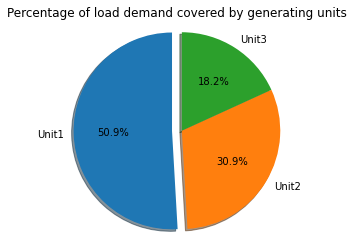

In [28]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = out_df.index.values.tolist()
print(labels)
sizes = out_df['Power[MW]'].tolist()
print(sizes)

#we want to "explode" the piece that has the greatest contribution in production
explode = [0] * len(sizes)
unit_max_contr = numpy.argmax(sizes)
explode[unit_max_contr] = 0.1

fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels, explode = explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.title("Percentage of load demand covered by generating units")
plt.show()


In [29]:

x = 27
[print(i) for i in range(0, x+1, 3)]


0
3
6
9
12
15
18
21
24
27


[None, None, None, None, None, None, None, None, None, None]